In [1]:
# Let's clean up the duplicate imports and retain only one instance of each.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, VarianceThreshold, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### Data Collection

In [2]:
import requests

# URLs of the files
data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/course/module5_course_feature_selection_and_dimensionality_reduction.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(data_url, 'module5_course_feature_selection_and_dimensionality_reduction.csv')

Downloaded module5_course_feature_selection_and_dimensionality_reduction.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/course/module5_course_feature_selection_and_dimensionality_reduction.csv


In [3]:
df = pd.read_csv('module5_course_feature_selection_and_dimensionality_reduction.csv')

## Data Analysis

In [4]:
df.shape

(569, 31)

In [5]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [6]:
X = df.drop('target', axis=1)
y = df['target']

# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### Feature Selection

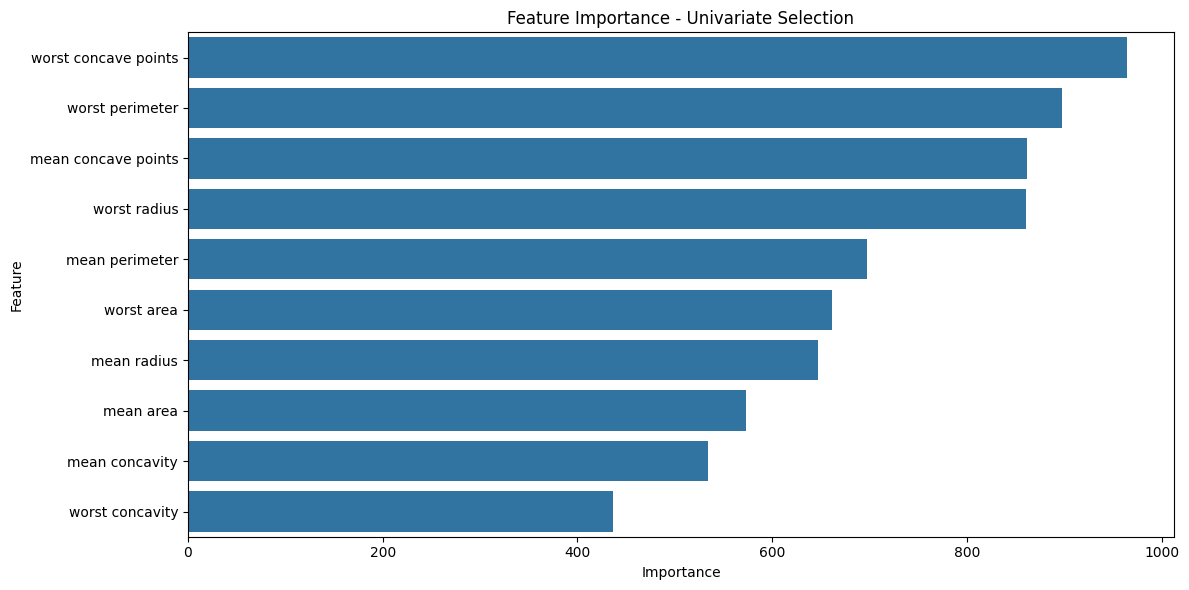

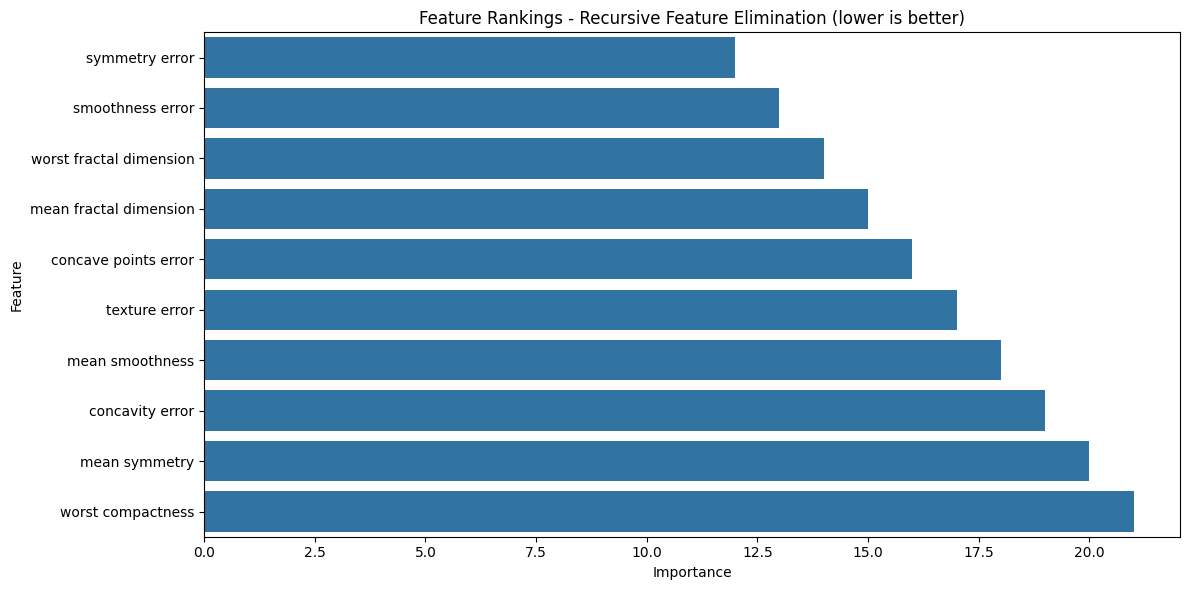

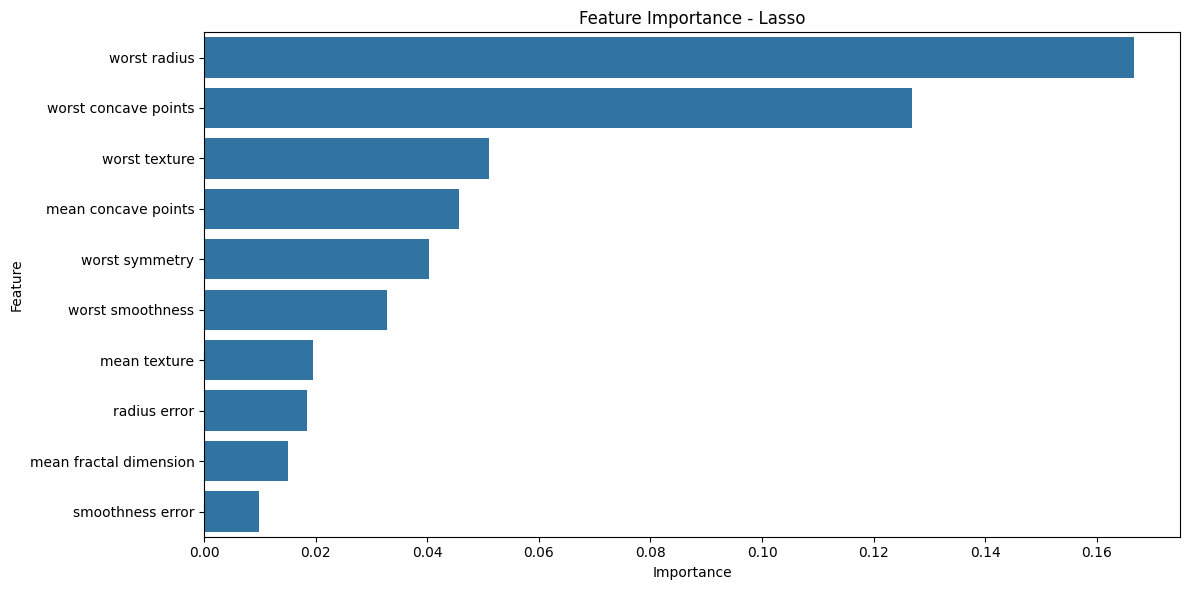

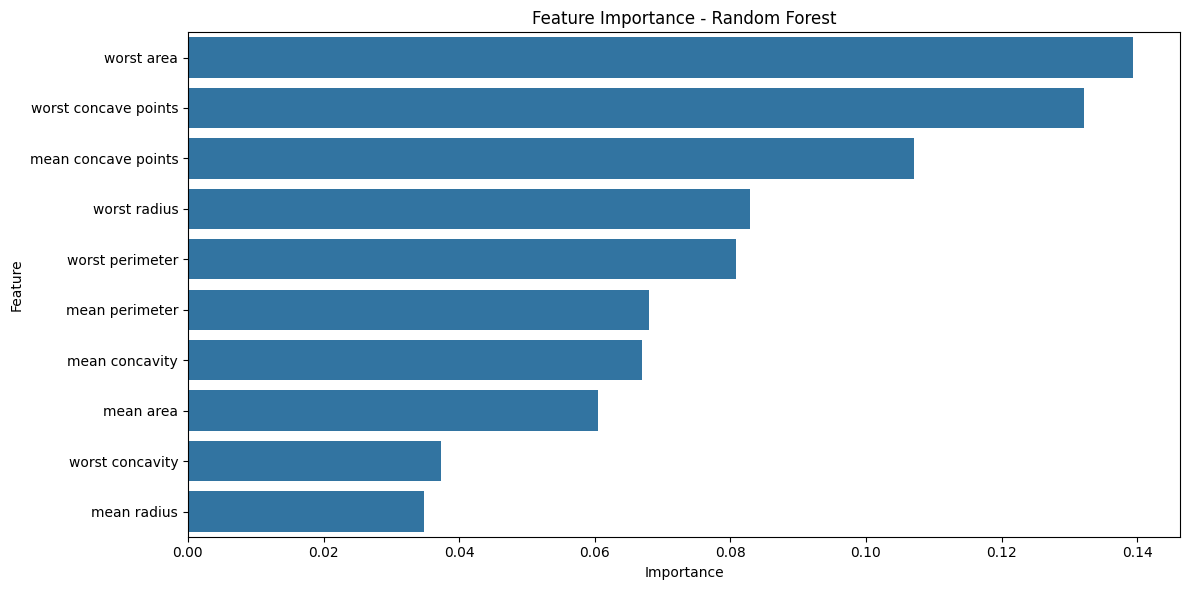

/tmp/ipykernel_16877/2315912218.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.   1.   0.25 0.1  0.5  0.9  0.8  1.   0.65 0.3  0.55 0.7  0.15 0.05
 0.6  0.85 1.   0.4  0.45 0.2  1.   0.   1.   1.   0.35 1.   1.   0.95
 0.75 1.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  summary_df.iloc[:, :] = scaler.fit_transform(summary_df)


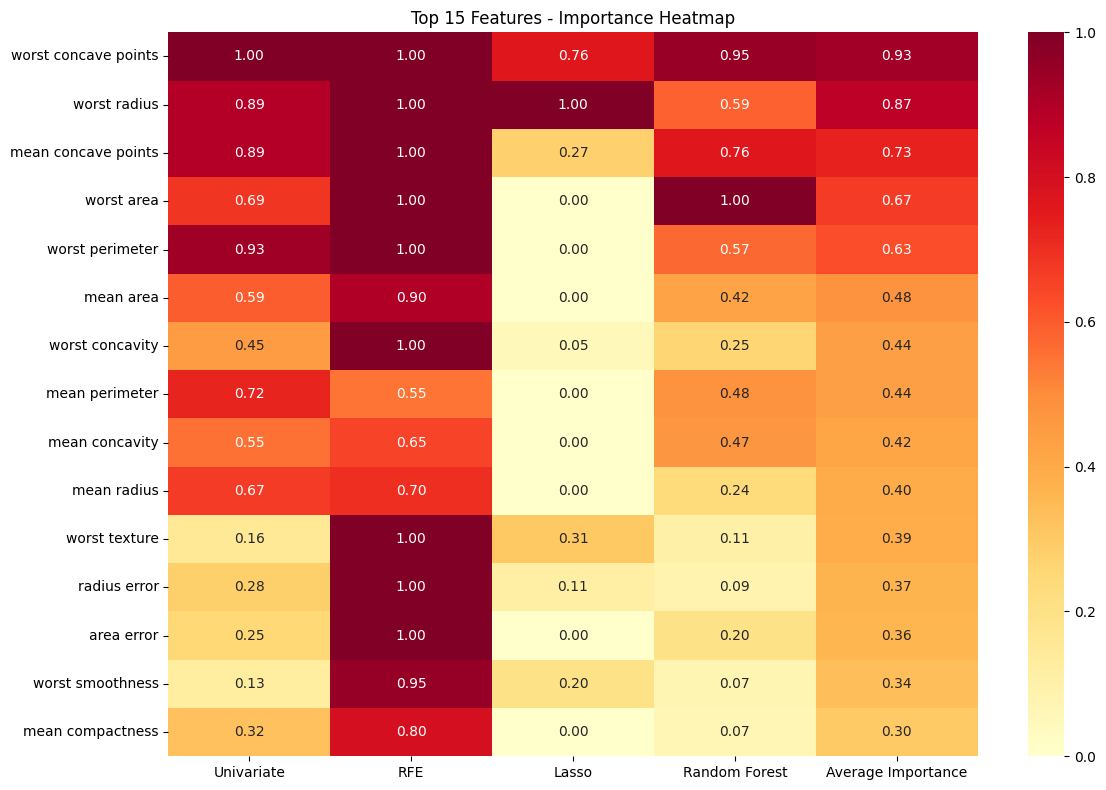

In [7]:
def plot_feature_importances(importances, title, top_n=10, ascending=False):
    plt.figure(figsize=(12, 6))
    
    importances_sorted = importances.sort_values(ascending=ascending)
    if ascending:
        sns.barplot(x=importances_sorted.values[-top_n:], y=importances_sorted.index[-top_n:])
    else:
        sns.barplot(x=importances_sorted.values[:top_n], y=importances_sorted.index[:top_n])
    plt.title(title)
    plt.ylabel('Feature')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# 1. Filter Methods
def univariate_feature_selection(X, y, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X, y)
    scores = pd.Series(selector.scores_, index=X.columns)
    return scores.sort_values(ascending=False)

univariate_scores = univariate_feature_selection(X_scaled, y)
plot_feature_importances(univariate_scores, 'Feature Importance - Univariate Selection')

# 2. Wrapper Methods
def recursive_feature_elimination(X, y, n_features_to_select=10):
    estimator = LogisticRegression(max_iter=1000)
    selector = RFE(estimator, n_features_to_select=n_features_to_select)
    selector = selector.fit(X, y)
    return pd.Series(selector.ranking_, index=X.columns).sort_values(ascending=True)

rfe_rankings = recursive_feature_elimination(X_scaled, y)
plot_feature_importances(rfe_rankings, 'Feature Rankings - Recursive Feature Elimination (lower is better)', ascending=True)

# 3. Embedded Methods
def lasso_feature_selection(X, y, alpha=0.01):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    importances = pd.Series(np.abs(lasso.coef_), index=X.columns)
    return importances.sort_values(ascending=False)

lasso_importances = lasso_feature_selection(X_scaled, y)
plot_feature_importances(lasso_importances, 'Feature Importance - Lasso')

def random_forest_feature_importance(X, y):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    return importances.sort_values(ascending=False)

rf_importances = random_forest_feature_importance(X_scaled, y)
plot_feature_importances(rf_importances, 'Feature Importance - Random Forest')

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Univariate': univariate_scores,
    'RFE': rfe_rankings,
    'Lasso': lasso_importances,
    'Random Forest': rf_importances
})
# Create a scaler instance
scaler = MinMaxScaler()

summary_df['RFE'] = 1 - summary_df['RFE'] 
summary_df.iloc[:, :] = scaler.fit_transform(summary_df)

# Calculate the average importance across all methods
summary_df['Average Importance'] = summary_df.mean(axis=1)

# Sort by average importance
summary_df = summary_df.sort_values('Average Importance', ascending=False)

# Display the top 15 features
# print("\nTop 15 Features Across All Methods:")
# print(summary_df.head(15))

# Visualize the top 15 features
plt.figure(figsize=(12, 8))
sns.heatmap(summary_df.head(15), annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Top 15 Features - Importance Heatmap')
plt.tight_layout()
plt.show()

### Dimensionality Reduction Techniques


Principal Component Analysis (PCA):
Number of components selected: 10
Total explained variance ratio: 0.9516


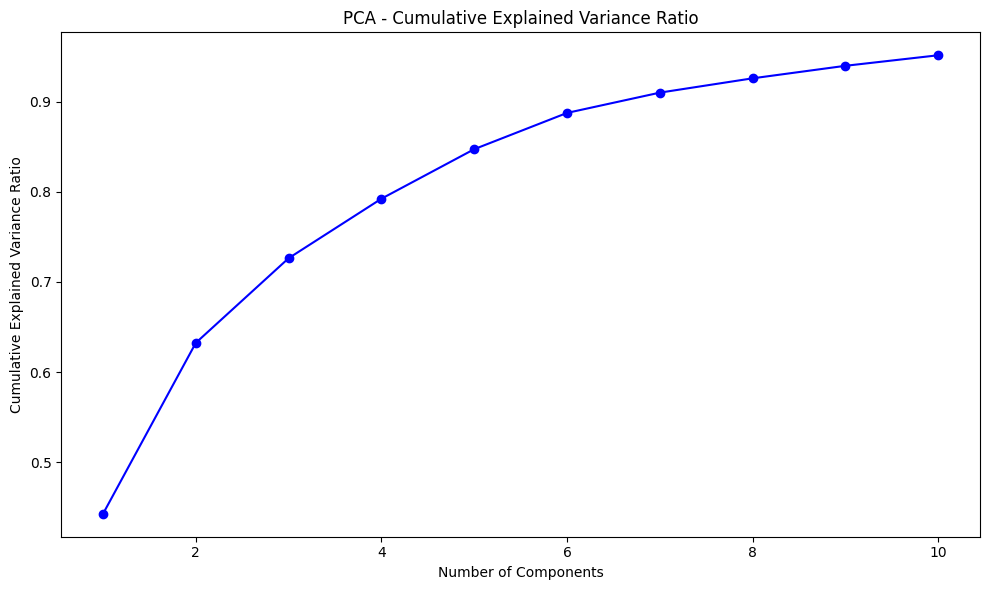

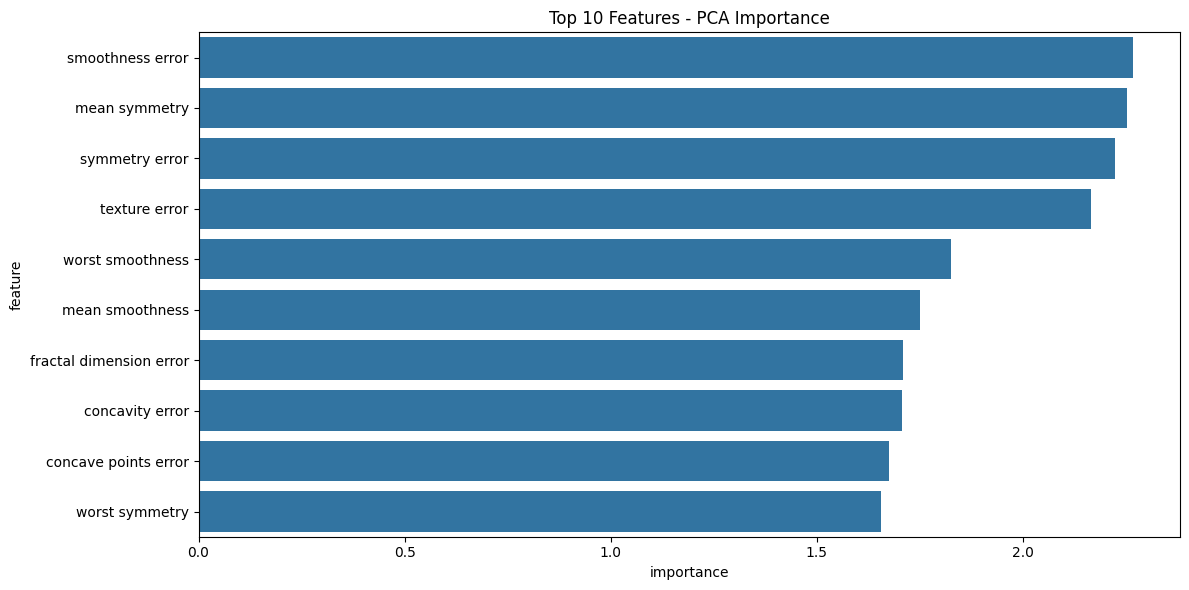

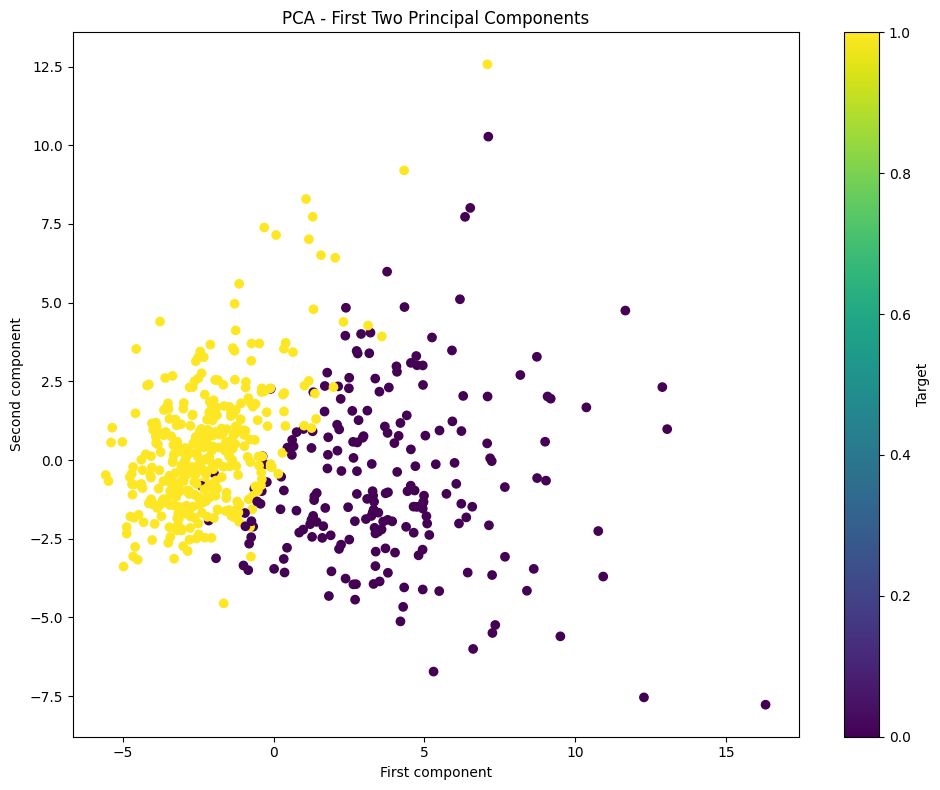


t-Distributed Stochastic Neighbor Embedding (t-SNE):
Using 2 components for visualization purposes


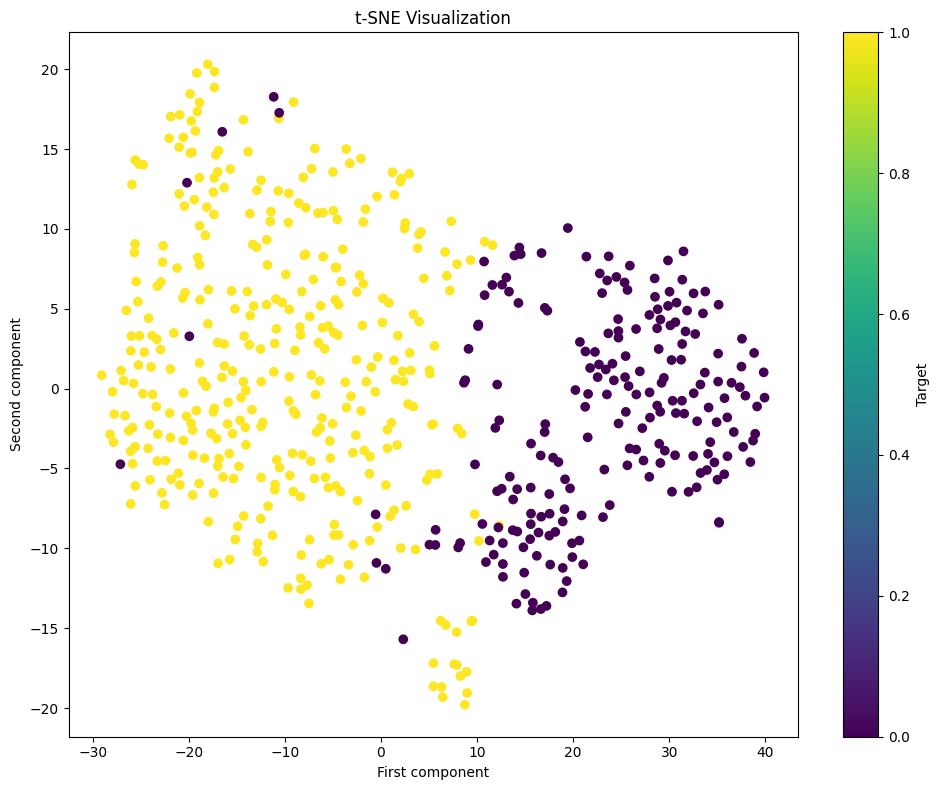


Linear Discriminant Analysis (LDA):
Explained variance ratio: 1.0000


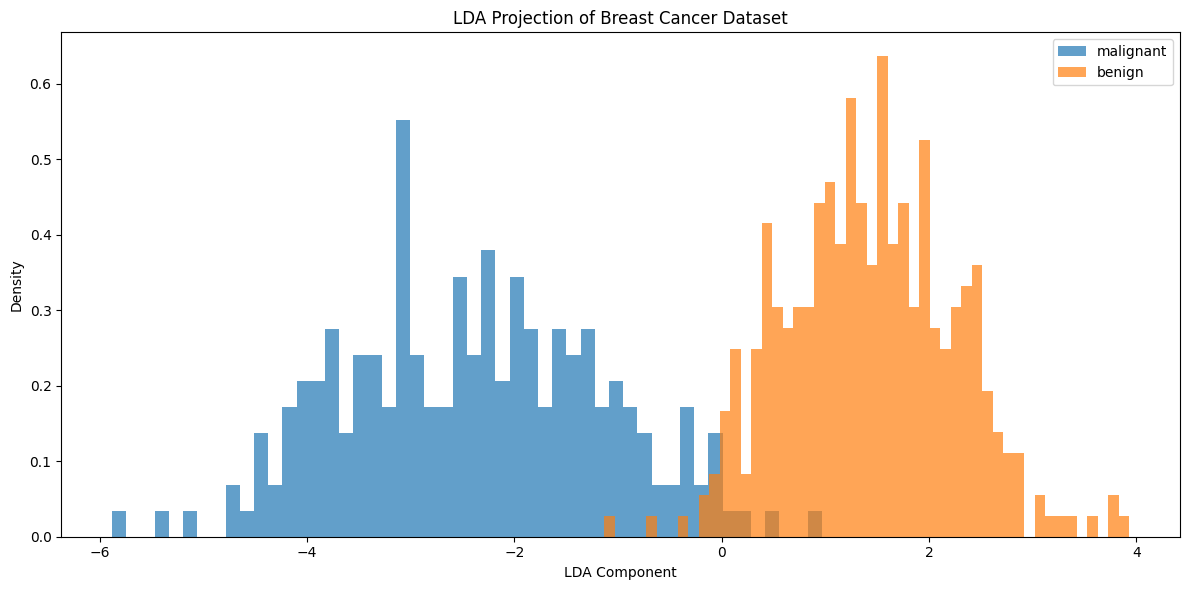

Class separation metric: 1.8541


In [8]:
def plot_2d_scatter(X_2d, y, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis')
    plt.colorbar(label='Target')
    plt.title(title)
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.tight_layout()
    plt.show()

# 1. Principal Component Analysis (PCA)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("\nPrincipal Component Analysis (PCA):")
print(f"Number of components selected: {pca.n_components_}")
print(f"Total explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA - Cumulative Explained Variance Ratio')
plt.tight_layout()
plt.show()

# PCA Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.sum(np.abs(pca.components_), axis=0)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Features - PCA Importance')
plt.tight_layout()
plt.show()

plot_2d_scatter(X_pca[:, :2], y, 'PCA - First Two Principal Components')

# 2. t-Distributed Stochastic Neighbor Embedding (t-SNE)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

print("\nt-Distributed Stochastic Neighbor Embedding (t-SNE):")
print("Using 2 components for visualization purposes")

plot_2d_scatter(X_tsne, y, 't-SNE Visualization')

# 3. Linear Discriminant Analysis (LDA)
lda = LDA()
X_lda = lda.fit_transform(X_scaled, y)

print("\nLinear Discriminant Analysis (LDA):")
print(f"Explained variance ratio: {lda.explained_variance_ratio_[0]:.4f}")

# Correct visualization for 1D LDA projection
plt.figure(figsize=(12, 6))
for i, target_name in enumerate(['malignant', 'benign']):
    plt.hist(X_lda[y == i], bins=50, density=True, alpha=0.7, label=target_name)

plt.xlabel('LDA Component')
plt.ylabel('Density')
plt.title('LDA Projection of Breast Cancer Dataset')
plt.legend()
plt.tight_layout()
plt.show()

# Additional analysis: separation metric
separation = np.abs(np.mean(X_lda[y == 0]) - np.mean(X_lda[y == 1])) / (np.std(X_lda[y == 0]) + np.std(X_lda[y == 1]))
print(f"Class separation metric: {separation:.4f}")

In [9]:
X_lda.shape

(569, 1)

## Data Preparation - Feature Selection And Dimensionality Reduction

In [10]:
# Define the evaluation function
def evaluate_strategy(X, y, strategy_name, transform_func):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = {'train': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
              'test': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}}
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if transform_func:
            X_train_transformed, X_test_transformed = transform_func(X_train, y_train,  X_test)
        else:
            X_train_transformed, X_test_transformed = X_train, X_test
        
        model = RandomForestClassifier()
        model.fit(X_train_transformed, y_train)
        
        for data_type, X_data, y_data in [('train', X_train_transformed, y_train),
                                          ('test', X_test_transformed, y_test)]:
            y_pred = model.predict(X_data)
            scores[data_type]['accuracy'].append(accuracy_score(y_data, y_pred))
            scores[data_type]['precision'].append(precision_score(y_data, y_pred))
            scores[data_type]['recall'].append(recall_score(y_data, y_pred))
            scores[data_type]['f1'].append(f1_score(y_data, y_pred))
    
    return scores

# Define transformation functions for each strategy
def univariate_transform(X, y, X_test, k=10):
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X, y)
    selected_cols = X.columns[selector.get_support()]
    return X[selected_cols], X_test[selected_cols]

def rfe_transform(X, y, X_test, n_features=10):
    estimator = RandomForestClassifier()
    selector = RFE(estimator, n_features_to_select=n_features)
    selector.fit(X, y)
    selected_cols = X.columns[selector.support_]
    return X[selected_cols], X_test[selected_cols]

def lasso_transform(X, y, X_test, alpha=0.01):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    selected_features = X.columns[lasso.coef_ != 0]
    return X[selected_features], X_test[selected_features]

def rf_transform(X, y, X_test, n_features=10):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    top_features = importances.nlargest(n_features).index
    return X[top_features], X_test[top_features]

def pca_transform(X, y, X_test, n_components=0.95):
    pca = PCA(n_components=n_components)
    combined_data = pd.concat([X, X_test])
    transformed_data = pca.fit_transform(combined_data)
    X_transform = transformed_data[:len(X)]
    X_test_transform = transformed_data[len(X):]
    return X_transform, X_test_transform

def tsne_transform(X, y, X_test, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=42)
    combined_data = pd.concat([X, X_test])
    transformed_data = tsne.fit_transform(combined_data)
    X_transform = transformed_data[:len(X)]
    X_test_transform = transformed_data[len(X):]
    return X_transform, X_test_transform

def lda_transform(X, y, X_test):
    lda = LDA()
    X_transform = lda.fit_transform(X, y)
    X_test_transform = lda.transform(X_test)
    return X_transform, X_test_transform

In [11]:
# Evaluate each strategy
strategies = {
    'None': None,
    'Univariate': univariate_transform,
    'RFE': rfe_transform,
    'Lasso': lasso_transform,
    'Random Forest': rf_transform,
    'PCA': pca_transform,
    't-SNE': tsne_transform,
    'LDA': lda_transform
}

results = {}
for name, func in strategies.items():
    print(f"Evaluating {name}...")
    results[name] = evaluate_strategy(X_scaled, y, name, func)

# Print summary
print("\nSummary of Results:")
print("-------------------")
for strategy, scores in results.items():
    print(f"\n{strategy}:")
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        # train_mean = np.mean(scores['train'][metric])
        test_mean = np.mean(scores['test'][metric])
        print(f"  {metric.capitalize()}: Test = {test_mean:.4f}")

Evaluating None...
Evaluating Univariate...
Evaluating RFE...
Evaluating Lasso...
Evaluating Random Forest...
Evaluating PCA...
Evaluating t-SNE...
Evaluating LDA...

Summary of Results:
-------------------

None:
  Accuracy: Test = 0.9578
  Precision: Test = 0.9619
  Recall: Test = 0.9720
  F1: Test = 0.9667

Univariate:
  Accuracy: Test = 0.9490
  Precision: Test = 0.9589
  Recall: Test = 0.9608
  F1: Test = 0.9595

RFE:
  Accuracy: Test = 0.9526
  Precision: Test = 0.9597
  Recall: Test = 0.9665
  F1: Test = 0.9625

Lasso:
  Accuracy: Test = 0.9684
  Precision: Test = 0.9754
  Recall: Test = 0.9748
  F1: Test = 0.9749

Random Forest:
  Accuracy: Test = 0.9490
  Precision: Test = 0.9614
  Recall: Test = 0.9580
  F1: Test = 0.9594

PCA:
  Accuracy: Test = 0.9473
  Precision: Test = 0.9590
  Recall: Test = 0.9581
  F1: Test = 0.9578

t-SNE:
  Accuracy: Test = 0.9613
  Precision: Test = 0.9573
  Recall: Test = 0.9833
  F1: Test = 0.9697

LDA:
  Accuracy: Test = 0.9614
  Precision: Test 

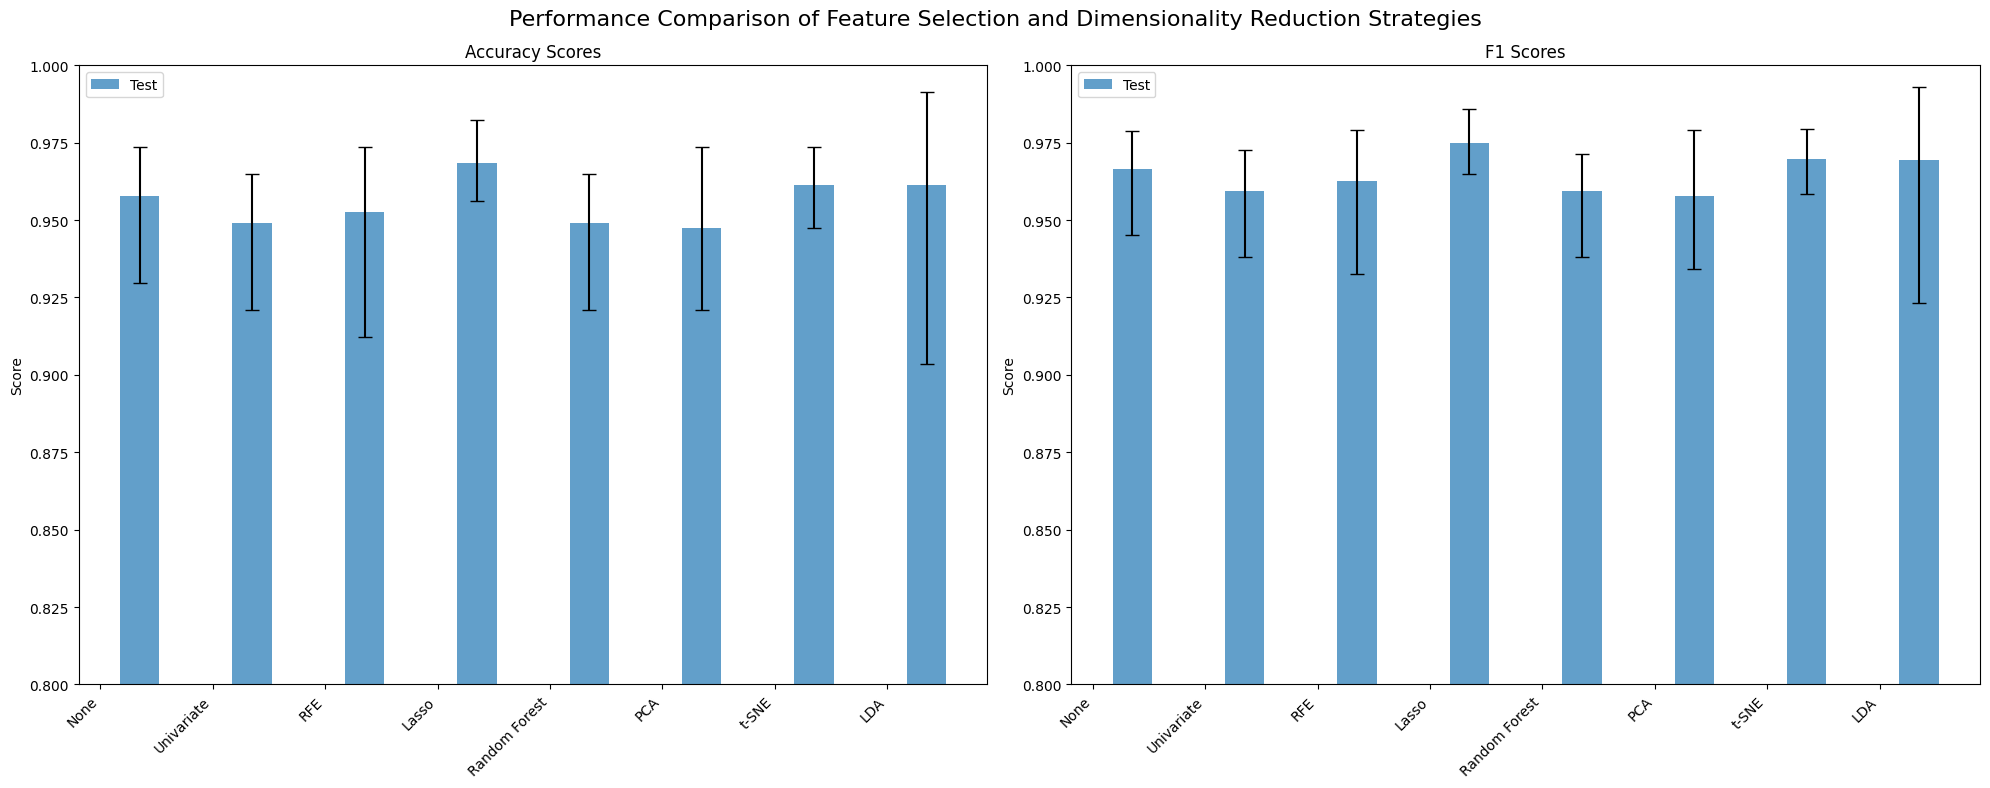

In [12]:

def plot_results(results):
    metrics = ['accuracy', 'f1']
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    for i, metric in enumerate(metrics):
        # train_values = [np.mean(results[strategy]['train'][metric]) for strategy in results]
        test_values = [np.mean(results[strategy]['test'][metric]) for strategy in results]
        # train_min = [np.min(results[strategy]['train'][metric]) for strategy in results]
        # train_max = [np.max(results[strategy]['train'][metric]) for strategy in results]
        test_min = [np.min(results[strategy]['test'][metric]) for strategy in results]
        test_max = [np.max(results[strategy]['test'][metric]) for strategy in results]
        
        x = np.arange(len(results))
        width = 0.35
        
        # axes[i].bar(x - width/2, train_values, width, 
        #             yerr=[np.array(train_values) - np.array(train_min), 
        #                   np.array(train_max) - np.array(train_values)], 
        #             label='Train', capsize=5, alpha=0.7)
        axes[i].bar(x + width, test_values, width, 
                    yerr=[np.array(test_values) - np.array(test_min), 
                          np.array(test_max) - np.array(test_values)], 
                    label='Test', capsize=5, alpha=0.7)
        
        axes[i].set_title(f'{metric.capitalize()} Scores')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(list(results.keys()), rotation=45, ha='right')
        axes[i].legend()
        axes[i].set_ylim(0.8, 1.0)  # Adjust as needed
        axes[i].set_ylabel('Score')
    
    plt.suptitle('Performance Comparison of Feature Selection and Dimensionality Reduction Strategies', fontsize=16)
    plt.tight_layout()
    plt.show()


# Usage
plot_results(results)
